In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (confusion_matrix, precision_recall_curve, recall_score, classification_report)
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

dt = pd.read_csv("../input/creditcard.csv")
dt.drop('Time', axis=1, inplace=True)

# Dataframe visualizations

In [2]:
dt.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Count')

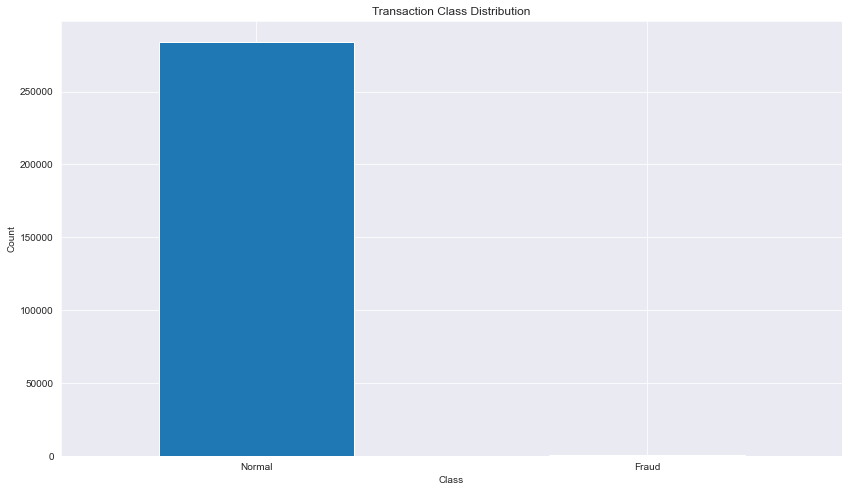

In [3]:
count_classes = pd.value_counts(dt['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
labels = ["Normal", "Fraud"]
plt.title("Transaction Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Count")

In [4]:
fraud = dt[dt['Class'] == 1]
normal = dt[dt['Class'] == 0]
outlier_fraction = len(fraud) / float(len(normal))
outlier_fraction

0.0017304750013189597

In [5]:
len(fraud)

492

#Preprocessing

In [6]:
def process_and_split_i_forest():
    dataframe = pd.read_csv("../input/creditcard.csv")
    dataframe.drop('Time', axis=1, inplace=True)
    target = dataframe["Class"]
    features = dataframe.drop("Class", axis=1)
    return train_test_split(features, target, test_size=0.33, random_state=42)

In [7]:
X_train, X_test, y_train, y_test = process_and_split_i_forest()
print(y_train[y_train == 1].shape, y_test[y_test == 1].shape)

(343,) (149,)


#Building the model

In [10]:
def parameter_tuning(parameters,scoring_function, X_train_param,y_train_param):
    grid_cv = GridSearchCV(IsolationForest(),
                       parameters,
                       scoring=scoring_function,
                       cv=3,
                       return_train_score=True)
    grid_cv.fit(X_train_param, y_train_param)
    return grid_cv.best_estimator_,grid_cv.cv_results_,grid_cv.best_params_

In [11]:
params = {'n_estimators': [50,100,150],
          'max_samples': ['auto',50000],
          'contamination': [outlier_fraction,outlier_fraction+0.001],
          'max_features': [25, 20, 15]}

scoring = make_scorer(recall_score,average='micro')
estimator,cv_result,best_params = parameter_tuning(params,scoring,X_train.values,y_train)

KeyboardInterrupt: 

In [ ]:
results_tree = pd.DataFrame(cv_result)
results_tree[['param_n_estimators', 'param_contamination', 'param_max_features', 'param_max_samples', 'mean_test_score',
              'rank_test_score']]

In [ ]:
best_params

In [ ]:
estimator

#Prediction and Result visualization

In [8]:
def simple_prediction(X_train_param,X_test_param,clf):
    prediction = clf.predict(X_test_param)
    prediction = np.array([1 if y == -1 else 0 for y in prediction])
    return prediction

In [ ]:
print(classification_report(y_test, simple_prediction(X_train,X_test,estimator)))

In [9]:
def confusion_heatmap(y_test_param, prediction_param):
    cf_matrix = confusion_matrix(y_test_param, prediction_param)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten() / np.sum(cf_matrix)]
    labels_ = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels_ = np.asarray(labels_).reshape(2, 2)
    categories = ['Normal', 'Fraud']
    sns.heatmap(cf_matrix, annot=labels_, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)

In [ ]:
confusion_heatmap(y_test, simple_prediction(X_train,X_test,estimator))

In [ ]:
score = estimator.score_samples(X_test.values)
score

In [ ]:
def visualize_curve(y_test_param,y_pred_param):
    precision, recall, th = precision_recall_curve(y_test_param,y_pred_param)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Precision Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [ ]:
visualize_curve(y_test.values, simple_prediction(X_train.values,X_test.values,estimator))